In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import seaborn as sns

In [2]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.4 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import en_core_web_sm
from spacy import displacy
from collections import Counter

In [5]:
data = []
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

371345
{'overall': 1.0, 'verified': True, 'reviewTime': '02 19, 2015', 'reviewerID': 'A1V6B6TNIC10QE', 'asin': '0143026860', 'reviewerName': 'theodore j bigham', 'reviewText': 'great', 'summary': 'One Star', 'unixReviewTime': 1424304000}


In [6]:
df = pd.DataFrame.from_dict(data)

print(len(df))

371345


In [7]:
print(df)

        overall  verified   reviewTime      reviewerID        asin  \
0           1.0      True  02 19, 2015  A1V6B6TNIC10QE  0143026860   
1           4.0      True  12 18, 2014  A2F5GHSXFQ0W6J  0143026860   
2           4.0      True  08 10, 2014  A1572GUYS7DGSR  0143026860   
3           5.0      True  03 11, 2013   A1PSGLFK1NSVO  0143026860   
4           5.0      True  12 25, 2011   A6IKXKZMTKGSC  0143026860   
...         ...       ...          ...             ...         ...   
371340      1.0      True  07 20, 2017  A202DCI7TV1022  B01HJEGTYK   
371341      5.0      True  03 16, 2017  A3FSOR5IJOFIBE  B01HJEGTYK   
371342      5.0      True   03 1, 2017  A1B5DK6CTP2P24  B01HJEGTYK   
371343      2.0      True  02 21, 2017  A23OUYS5IRMJS9  B01HJEGTYK   
371344      2.0      True  12 15, 2016  A24KQ9RVU81L87  B01HJEGTYK   

             reviewerName                                         reviewText  \
0       theodore j bigham                                              great   

In [8]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


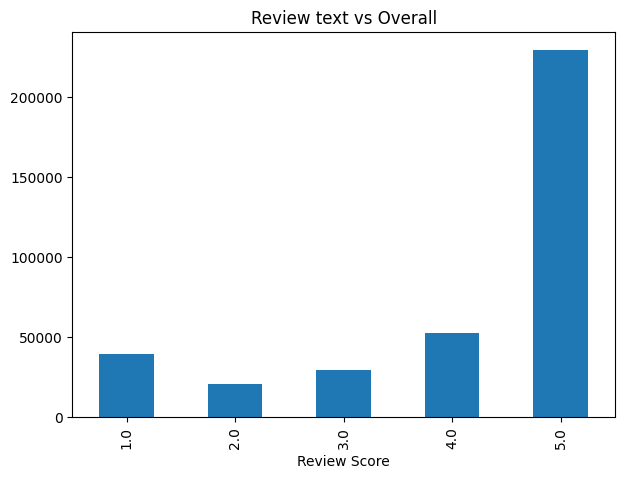

In [10]:
ax = df['overall'].value_counts().sort_index()\
    .plot(kind= 'bar', 
    title = 'Review text vs Overall', 
    figsize=(7,5))
ax.set_xlabel('Review Score')
plt.show()

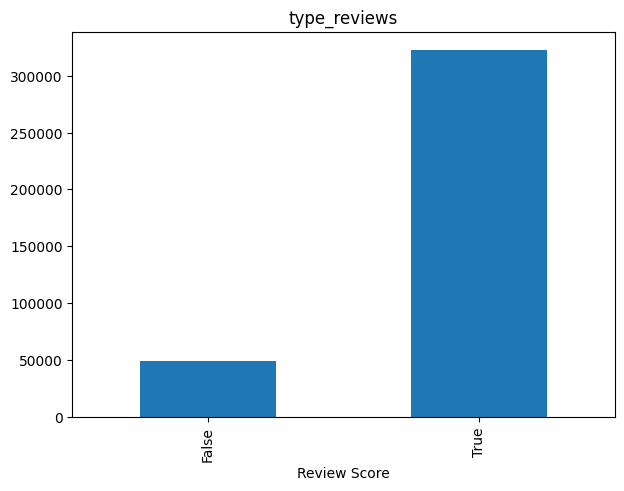

In [10]:
ax = df['verified'].value_counts().sort_index()\
    .plot(kind= 'bar', 
    title = 'type_reviews', 
    figsize=(7,5))
ax.set_xlabel('Review Score')
plt.show()

Without having eliminated fake reviews, the vast majority of reviews are positive with a ranking of 5, followed by a ranking of 4.

In [11]:
df.shape

(371345, 12)

In [12]:
df.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
style              object
image              object
dtype: object

In [13]:
amazon_re = df[['overall','reviewerID', 'verified', 'reviewText']].copy()


In [14]:
amazon_re.head()

,overall,reviewerID,verified,reviewText
0,1.0,A1V6B6TNIC10QE,True,great
1,4.0,A2F5GHSXFQ0W6J,True,My husband wanted to reading about the Negro ...
2,4.0,A1572GUYS7DGSR,True,"This book was very informative, covering all a..."
3,5.0,A1PSGLFK1NSVO,True,I am already a baseball fan and knew a bit abo...
4,5.0,A6IKXKZMTKGSC,True,This was a good story of the Black leagues. I ...


In [15]:
amazon_re = amazon_re.loc[amazon_re['verified'] != False]


In [16]:
amazon_re.shape

(322473, 4)

In [17]:
amazon_re.head()

,overall,reviewerID,verified,reviewText
0,1.0,A1V6B6TNIC10QE,True,great
1,4.0,A2F5GHSXFQ0W6J,True,My husband wanted to reading about the Negro ...
2,4.0,A1572GUYS7DGSR,True,"This book was very informative, covering all a..."
3,5.0,A1PSGLFK1NSVO,True,I am already a baseball fan and knew a bit abo...
4,5.0,A6IKXKZMTKGSC,True,This was a good story of the Black leagues. I ...


In [18]:
amazon_re.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322473 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     322473 non-null  float64
 1   reviewerID  322473 non-null  object 
 2   verified    322473 non-null  bool   
 3   reviewText  322098 non-null  object 
dtypes: bool(1), float64(1), object(2)
memory usage: 10.1+ MB


Deleting NULL

In [19]:
filas_con_nulos = amazon_re.isnull().any(axis=1)


In [20]:
cantidad_filas_con_nulos = filas_con_nulos.sum()
print("Row with null values:", cantidad_filas_con_nulos)


Row with null values: 375


In [21]:
amazon_re = amazon_re.dropna()


In [22]:
filas_con_nulos = amazon_re.isnull().any(axis=1)
cantidad_filas_con_nulos = filas_con_nulos.sum()
print("Cantidad de filas con valores nulos:", cantidad_filas_con_nulos)

Cantidad de filas con valores nulos: 0


In [23]:
amazon_re.shape

(322098, 4)

In [24]:
amazon_re.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322098 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     322098 non-null  float64
 1   reviewerID  322098 non-null  object 
 2   verified    322098 non-null  bool   
 3   reviewText  322098 non-null  object 
dtypes: bool(1), float64(1), object(2)
memory usage: 10.1+ MB


In [25]:
amazon_re.describe()['overall'].T

count    322098.000000
mean          4.113881
std           1.361587
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [26]:
amazon_re = amazon_re[['overall','reviewerID', 'reviewText']].copy()


In [27]:
#X = amazon_re.reviewText.values

# Changes values from [0,4] to [0,1]
#y = (amazon_re.overall.values > 1).astype(int)


# Split the data into train and test
#x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


#Proposal 2

# 0: Negative (0-1), 1: Neutral (2-3), 2: Positive (4-5)
def label_polarity(value):
    if value <= 1:
        return 0
    elif value <= 3:
        return 1
    else:
        return 2

amazon_re['polarity'] = amazon_re['overall'].apply(label_polarity)

X = amazon_re.reviewText.values
y = amazon_re['polarity'].values

# divition of test and train data
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [28]:
for s, l in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(l, s))

2: This stuff is perfect. I've used Dr. Bronner before, but I like this better. It smells sooo good, and leaves my hands feeling very soft. I bought a Bath and Body Works Foaming Soap, and emptied the contents. Then I fill the container about 1/3 of the way with the Castile Soap, the rest with water, and replace top. It works exactly like a foaming hand soap. I just keep refilling the soap dispenser over and over with the Castile Soap & water mix- its much cheaper then buying a BBW soap each time.
2: This little device comes with a lot for the price. I was very pleased with what all came with it. Works very well and does a great job of cleaning in between your teeth. If you hate flossing (like I do) this is a great and way easier alternative.
2: Perfect!!!!
2: Absolutely fantastic buy and will continue to purchase ! No bumps, redness, or irritation. My who-ha has been very happy :)
0: There only 4 bottles, not 6 as advertised!


Tokenization

In [29]:
tokenizer = get_tokenizer("basic_english")

print('Before Tokenize: ', x_train_text[1])
print('After Tokenize: ', tokenizer(x_train_text[1]))

Before Tokenize:  This little device comes with a lot for the price. I was very pleased with what all came with it. Works very well and does a great job of cleaning in between your teeth. If you hate flossing (like I do) this is a great and way easier alternative.
After Tokenize:  ['this', 'little', 'device', 'comes', 'with', 'a', 'lot', 'for', 'the', 'price', '.', 'i', 'was', 'very', 'pleased', 'with', 'what', 'all', 'came', 'with', 'it', '.', 'works', 'very', 'well', 'and', 'does', 'a', 'great', 'job', 'of', 'cleaning', 'in', 'between', 'your', 'teeth', '.', 'if', 'you', 'hate', 'flossing', '(', 'like', 'i', 'do', ')', 'this', 'is', 'a', 'great', 'and', 'way', 'easier', 'alternative', '.']


In [30]:
nlp = spacy.load('en_core_web_sm')


In [31]:
# Tokenize each review in the reviewText column

tokenized_train_reviews = []


In [32]:
import time

sample_data = amazon_re['reviewText'].sample(n=1000)

start_time = time.time()

start_time = time.time()

tokenized_reviews = []
for review in sample_data:
    tokens = nlp(review)
    tokenized_reviews.append([token.text for token in tokens])

end_time = time.time()
total_time = end_time - start_time
print("Total tokenization time for 1000 data:", total_time, "seconds")

estimation_time = total_time * (400000 / 1000)
print("Time estimate for 400,000 data:", estimation_time, "seconds")

Total tokenization time for 1000 data: 9.14308786392212 seconds
Time estimate for 400,000 data: 3657.2351455688477 seconds


In [33]:
# Tokenize training data (x_train_text)
tokenized_train_reviews = []

for review in x_train_text:
    tokens = nlp(review)
    tokenized_train_reviews.append([token.text for token in tokens])

# Convert training token list to Python list
tokenized_train_reviews = list(tokenized_train_reviews)

# Tokenize test data (x_test_text)
tokenized_test_reviews = []

for review in x_test_text:
    tokens = nlp(review)
    tokenized_test_reviews.append([token.text for token in tokens])

# Convert test token list to Python list
tokenized_test_reviews = list(tokenized_test_reviews)

In [37]:
print('Before Tokenize: ', x_train_text[34000])
print('After Tokenize: ', tokenizer(x_train_text[34000]))

Before Tokenize:  this device works as advertised and has made a noticeable improvement to my dental health.  I was never a fan of the old style flossing but i am a huge fan of water flossing
After Tokenize:  ['this', 'device', 'works', 'as', 'advertised', 'and', 'has', 'made', 'a', 'noticeable', 'improvement', 'to', 'my', 'dental', 'health', '.', 'i', 'was', 'never', 'a', 'fan', 'of', 'the', 'old', 'style', 'flossing', 'but', 'i', 'am', 'a', 'huge', 'fan', 'of', 'water', 'flossing']


In [38]:
x_train_token = [tokenizer(s) for s in (tqdmx_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

100%|██████████| 64420/64420 [00:01<00:00, 49249.75it/s]


In [39]:
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 72880
['.', 'i', 'the', 'it', 'and', ',', 'a', 'to', "'", 'this', 'my', '!', 'is', 'for', 'of', 'but', 'in', 'that', 'not', 'have', 't', 'on', 'with', 'was', 'product', 'you', 'great', 'so', 'as', 'very', 'love', 'use', 's', 'like', 'good', 'they', 'are', 'hair', 'one', 'just', 'be', 'all', 'skin', 'me', 'will', 'well', 'at', 'these', 'really', 'would', 'if', 'out', 'can', 'or', 'works', 'when', 'had', ')', 'your', 'get', 'them', 'more', 'used', 'after', 'than', 'has', 'using', 'time', '(', 'from', 'no', 'only', 'up', 'don', 'what', 'much', 'does', 'do', 'too', 'nice', 'price', 'little', 'because', 'about', 've', 'been', 'am', 'work', 'm', 'other', 'an', 'also', 'buy', 'color', 'even', 'bought', 'better', 'long', 'some', 'off']


Logistic regression

In [40]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [41]:
print('Before Vectorize: ', x_train_text[3])


Before Vectorize:  Absolutely fantastic buy and will continue to purchase ! No bumps, redness, or irritation. My who-ha has been very happy :)


In [42]:
# Notice that the matriz is sparse
print('After Vectorize: ')
print(x_train_cv[3])

After Vectorize: 
  (0, 3854)	1
  (0, 32415)	1
  (0, 52291)	1
  (0, 2300)	1
  (0, 19094)	1
  (0, 8873)	1
  (0, 53777)	1
  (0, 12133)	1
  (0, 49541)	1
  (0, 38789)	1
  (0, 33210)	1
  (0, 8666)	1
  (0, 40118)	1
  (0, 34460)	1
  (0, 26462)	1
  (0, 53632)	1
  (0, 22862)	1
  (0, 23317)	1
  (0, 6659)	1
  (0, 23211)	1


In [43]:
model = LogisticRegression(solver='saga')
model.fit(x_train_cv, y_train)

/Users/jimmy/Projects/neuromatch-projects/.conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [49]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(intercept_scaling=5, solver='saga')

In [50]:
y_pred = model.predict(x_test_cv)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67      6760
           1       0.55      0.39      0.45      8769
           2       0.90      0.96      0.93     48891

    accuracy                           0.84     64420
   macro avg       0.71      0.66      0.68     64420
weighted avg       0.83      0.84      0.83     64420



In [51]:
print(model.coef_.shape)
print(len(vectorizer.vocabulary_))

words_sk = list(vectorizer.vocabulary_.keys())
words_sk.sort(key=lambda w: model.coef_[0, vectorizer.vocabulary_[w]])

(3, 55010)
55010


In [52]:
for w in words_sk[:20]:
  print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

loves: -1.4780996525544479
happier: -1.4731633238439517
complaints: -1.4601381454377051
amazing: -1.3476104459976899
love: -1.3135690461103837
beat: -1.2402985632717023
excellent: -1.1918015874836645
heavenly: -1.1892690507737729
great: -1.1690724207276204
sturdy: -1.1643078249532082
worried: -1.162316772644402
wonderful: -1.158006808966176
beautiful: -1.1454496683791602
cleared: -1.127953888255121
awesome: -1.1143012836434825
best: -1.1018755437547143
perfect: -1.0930886587339845
nervous: -1.0925066134273769
nice: -1.0886226576015454
lovely: -1.0845176966937957


In [53]:
for w in reversed(words_sk[-20:]):
  print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

worst: 1.9107330675932173
unusable: 1.7266203620081508
junk: 1.7061982473468669
crap: 1.6706343898633185
horrible: 1.6371884649006079
worthless: 1.5533261585373177
garbage: 1.5379568709487603
zero: 1.5086151006273731
terrible: 1.5077607741363799
unhappy: 1.4799408970672447
awful: 1.3994914526556665
useless: 1.3860875084497943
tampered: 1.3778014975040918
sucks: 1.3660184031872953
scam: 1.352720028873546
trash: 1.341823592075888
dissapointed: 1.317526349246629
dissatisfied: 1.317031271875328
ineffective: 1.3164348220289397
ugh: 1.3142922439391636
